## Simple classifier

In [1]:
%matplotlib inline

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import noise
import MotionClouds as mc

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [5]:
from LogGabor import LogGabor

In [78]:
#import SLIP for whitening and PIL for resizing
import SLIP
import PIL
whit = SLIP.Image(pe='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py')

## Noise stuff

In [6]:
def MotionCloudNoise(sf_0=0.125, B_sf=3., alpha = .5):
    mc.N_X, mc.N_Y, mc.N_frame = 128, 128, 1
    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    name = 'static'
    env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=B_sf, B_theta=np.inf, V_X=0., V_Y=0., B_V=0, alpha= alpha)
    
    z = mc.rectif(mc.random_cloud(env))
    z = z.reshape((mc.N_X, mc.N_Y))
    return z, env


### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

In [7]:
# TODO: passer les arguments par la ligne de commande
N_theta = 6
N_azimuth = 16
N_eccentricity = 8
N_phase = 2
N_X = 128
N_Y = 128
rho = 1.41
verbose = 1


#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [8]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=.8, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                psi = i_azimuth * np.pi * 2 / N_azimuth
                theta_ref = i_theta*np.pi/N_theta
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos(psi)
                y = N_Y/2 + r * np.sin(psi)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': theta_ref + psi, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel() * ecc

    return retina


#### Full encoding

In [10]:
retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina.shape)

(6, 16, 8, 2, 16384)


In [11]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1536, 16384)


In [12]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1536)


#### Orientation invariant power encoding (colliculus??)

In [13]:
colliculus = (retina**2).sum(axis=(0, 3))
colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(16, 8, 16384)


In [14]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(128, 16384)


In [15]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 128)


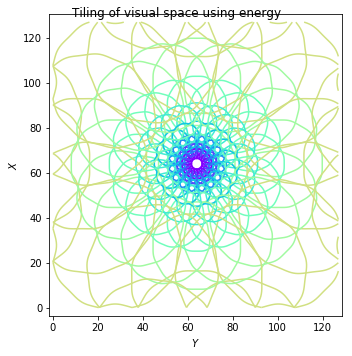

In [16]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

#### MNIST dataset read out

In [17]:
def get_data_loader(batch_size=100, train=True):
    data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/tmp/data',
                       train=train,     # def the dataset as training data
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0,), std=(1,))])),
                       batch_size=batch_size,
                       shuffle=True)
    return data_loader


In [91]:
loader = get_data_loader(batch_size=100, train = False)

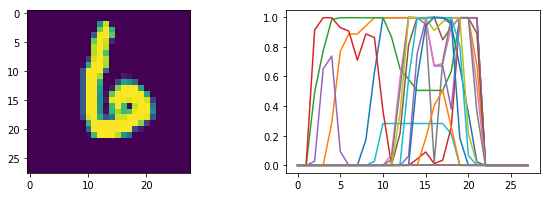

In [92]:
data, label = next(iter(loader))
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(data[0,0,:,:])
plt.subplot(122)
_ = plt.plot(data[0,0,:,:])

### From MNIST encoding

#### Input vectors encoding

In [110]:
def mnist_fullfield(data, i_offset, j_offset, N_pic=128, CONTRAST=1., NOISE = 1., sf_0 = 0.1, B_sf = 0.1):
    N_stim = data.shape[0]
    center = (N_pic-N_stim)//2

    data_fullfield = (data.min().numpy()) * np.ones((N_pic, N_pic))
    data_fullfield[int(center+i_offset):int(center+N_stim+i_offset), int(center+j_offset):int(center+N_stim+j_offset)] = data

    # data normalization
    # data_fullfield -= data_fullfield.mean()
    # data_fullfield /= data_fullfield.std()
    # data_fullfield *= std
    # data_fullfield += mean
    data_fullfield = (data_fullfield - data_fullfield.min())/(data_fullfield.max() - data_fullfield.min())
    data_fullfield *= CONTRAST
    data_fullfield += 0.5

    if NOISE>0.:
        im_noise, _ = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf)
        im_noise = NOISE *  im_noise
        #data_fullfield += im_noise #randomized_perlin_noise() #
        indices_data = np.where(data_fullfield > data_fullfield.mean())
        im_noise[indices_data] = data_fullfield[indices_data]
        data_fullfield = im_noise
    
    whit.set_size((N_pic,N_pic))
    data_fullfield = whit.whitening(data_fullfield)

    data_retina = retina_vector @ np.ravel(data_fullfield)
    
    tensor_retina = data_retina.reshape(N_theta, N_azimuth, N_eccentricity, N_phase)
    slice1 = tensor_retina[N_theta - 1,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
    slice2 = tensor_retina[0,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
    tensor_retina = np.concatenate ((slice1, tensor_retina, slice2), axis = 0)
    tensor_retina = np.transpose(tensor_retina,(3,0,1,2))

    return data_retina, tensor_retina, data_fullfield

#### Utilitaires

In [88]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

# Hyperparameters

In [99]:
minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-3 #0.05

OFFSET_STD = 0 #15 #
OFFSET_MAX = 0 #30 #
NOISE = 1 #0 #
CONTRAST = 0.3 #1 #
sf_0 = 0.2
B_sf = 0.3

### Test

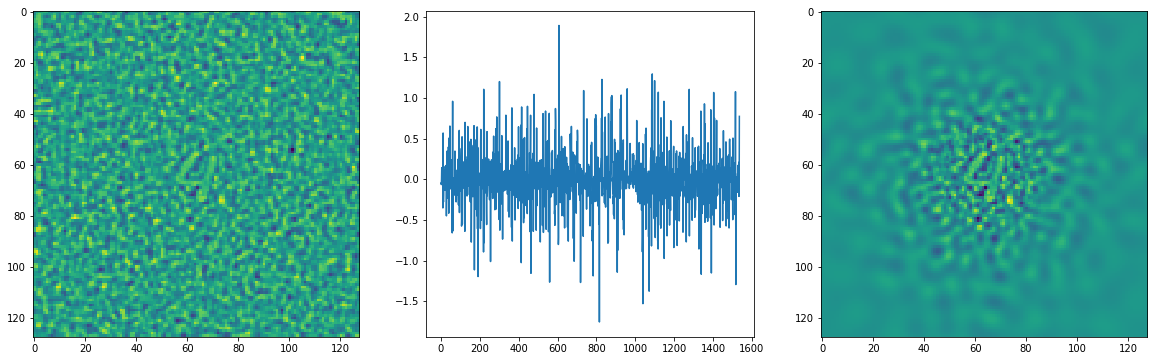

In [111]:
if True:
    i = 4
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    retina, _, image = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                    sf_0 = sf_0, B_sf = B_sf)
    #plt.imshow(input_test)
    plt.figure(figsize = (20,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    f = plt.plot(retina)
    plt.subplot(133)
    im = retina_inverse @ retina
    plt.imshow(im.reshape(128, 128))


#### Torch stuff

In [112]:
do_cuda = False # torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [113]:
train_loader = get_data_loader(batch_size=minibatch_size, train = True)
test_loader = get_data_loader(batch_size=1000, train = False)

# Network

In [114]:
BIAS_CONV = True
BIAS_DECONV = True #True

class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.bn1= torch.nn.Linear(N_theta*N_azimuth*N_eccentricity*N_phase, 200, bias = BIAS_DECONV)
        self.bn2 = torch.nn.Linear(200, 80, bias = BIAS_DECONV)
        self.bn3 = torch.nn.Linear(80, 10, bias = BIAS_DECONV)
                
    def forward(self, image):
       
        h_bn1 = F.relu(self.bn1(image))               
        h_bn2 = F.relu(self.bn2(h_bn1))
        h_bn2_drop = F.dropout(h_bn2, p = .5) 
        z = self.bn3(h_bn2_drop)
        
        return z


In [115]:
net = Net()

In [116]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [117]:
loss_func = torch.nn.CrossEntropyLoss()

In [118]:
#### Training

In [119]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = 1, \
          offset_std=OFFSET_STD, \
          offset_max=OFFSET_MAX, \
          verbose=1, \
          CONTRAST=CONTRAST,
          NOISE = NOISE,
          sf_0 = sf_0, 
          B_sf = B_sf):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        data_retina = np.zeros((minibatch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
        # target = np.zeros((minibatch_size, asize))

        for i in range(minibatch_size):
            i_offset = minmax(np.random.randn() * offset_std, offset_max)
            j_offset = minmax(np.random.randn() * offset_std, offset_max)
            data_retina[i, :], _, _  = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                                        CONTRAST = CONTRAST, NOISE = NOISE,
                                                        sf_0 = sf_0, B_sf = B_sf)            

        data_retina, label = Variable(torch.FloatTensor(data_retina)), Variable(torch.LongTensor(label))
        prediction = net(data_retina)
        loss = loss_func(prediction, label)
        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            print('[{}/{}] Loss: {} Time: {:.2f} mn'.format(
                batch_idx*minibatch_size, len(train_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))
                                                        
    return net


In [120]:
def test(net, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity, offset_std=OFFSET_STD, offset_max=OFFSET_MAX, 
         CONTRAST=CONTRAST, NOISE = NOISE,
         sf_0 = sf_0, 
         B_sf = B_sf):
    #for batch_idx, (data, label) in enumerate(test_loader):
    data, label = next(iter(test_loader))
    batch_size = label.shape[0]

    data_retina = np.zeros((batch_size, N_phase * N_theta * N_azimuth * N_eccentricity))

    for i in range(batch_size):
        i_offset = minmax(np.random.randn() * offset_std, offset_max)
        j_offset = minmax(np.random.randn() * offset_std, offset_max)
        data_retina[i, :], _, _  = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                                    sf_0 = sf_0, B_sf = B_sf)


    data_retina, label = Variable(torch.FloatTensor(data_retina)), Variable(torch.LongTensor(label))
    with torch.no_grad():
        output = net(data_retina)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        #pred = Variable(torch.LongTensor(pred))
        #print(pred.data.numpy())
        acc = pred.eq(label.view_as(pred)).sum().item()

    return acc / batch_size


## Central target, with noise

#### Background noise + whitening

In [121]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.309953212738037 Time: 0.07 mn
[1000/60000] Loss: 2.2830376625061035 Time: 0.90 mn
[2000/60000] Loss: 2.221451759338379 Time: 2.03 mn
[3000/60000] Loss: 2.110159397125244 Time: 3.06 mn
[4000/60000] Loss: 1.8804866075515747 Time: 4.16 mn
[5000/60000] Loss: 1.5605955123901367 Time: 5.22 mn
[6000/60000] Loss: 1.5149203538894653 Time: 6.24 mn
[7000/60000] Loss: 1.2871596813201904 Time: 7.18 mn
[8000/60000] Loss: 1.368293285369873 Time: 8.12 mn
[9000/60000] Loss: 1.0355725288391113 Time: 9.11 mn
[10000/60000] Loss: 1.071363925933838 Time: 10.12 mn
[11000/60000] Loss: 1.1884710788726807 Time: 11.01 mn
[12000/60000] Loss: 0.9299375414848328 Time: 11.96 mn
[13000/60000] Loss: 1.2718474864959717 Time: 12.84 mn
[14000/60000] Loss: 1.078321933746338 Time: 13.57 mn
[15000/60000] Loss: 0.9850507378578186 Time: 14.26 mn
[16000/60000] Loss: 1.0164889097213745 Time: 15.00 mn
[17000/60000] Loss: 1.3077014684677124 Time: 15.74 mn
[18000/60000] Loss: 0.92790877819061

[31000/60000] Loss: 0.29764270782470703 Time: 32.84 mn
[32000/60000] Loss: 0.40249693393707275 Time: 33.80 mn
[33000/60000] Loss: 0.3980417549610138 Time: 34.74 mn
[34000/60000] Loss: 0.5165773034095764 Time: 35.66 mn
[35000/60000] Loss: 0.6133431792259216 Time: 36.57 mn
[36000/60000] Loss: 0.5026665925979614 Time: 37.48 mn
[37000/60000] Loss: 0.4174705743789673 Time: 38.39 mn
[38000/60000] Loss: 0.37558218836784363 Time: 39.30 mn
[39000/60000] Loss: 0.5029008388519287 Time: 40.22 mn
[40000/60000] Loss: 0.325972318649292 Time: 41.14 mn
[41000/60000] Loss: 0.5525549054145813 Time: 42.08 mn
[42000/60000] Loss: 0.38096246123313904 Time: 43.05 mn
[43000/60000] Loss: 0.5633298754692078 Time: 44.10 mn
[44000/60000] Loss: 0.4651050269603729 Time: 45.15 mn
[45000/60000] Loss: 0.4209064841270447 Time: 46.10 mn
[46000/60000] Loss: 0.4927234947681427 Time: 47.27 mn
[47000/60000] Loss: 0.6177310347557068 Time: 48.22 mn
[48000/60000] Loss: 0.36356663703918457 Time: 49.21 mn
[49000/60000] Loss: 0.46

[0/60000] Loss: 0.3441556990146637 Time: 0.09 mn
[1000/60000] Loss: 0.4779444932937622 Time: 0.96 mn
[2000/60000] Loss: 0.3856649696826935 Time: 1.84 mn
[3000/60000] Loss: 0.27915775775909424 Time: 2.75 mn
[4000/60000] Loss: 0.4246959388256073 Time: 3.86 mn
[5000/60000] Loss: 0.444227397441864 Time: 4.78 mn
[6000/60000] Loss: 0.3044371008872986 Time: 5.69 mn
[7000/60000] Loss: 0.35933199524879456 Time: 6.57 mn
[8000/60000] Loss: 0.24019818007946014 Time: 7.46 mn
[9000/60000] Loss: 0.4124715328216553 Time: 8.41 mn
[10000/60000] Loss: 0.5595106482505798 Time: 9.34 mn
[11000/60000] Loss: 0.36029887199401855 Time: 10.28 mn
[12000/60000] Loss: 0.31620994210243225 Time: 11.33 mn
[13000/60000] Loss: 0.3575408458709717 Time: 12.27 mn
[14000/60000] Loss: 0.32204562425613403 Time: 13.14 mn
[15000/60000] Loss: 0.37222546339035034 Time: 14.04 mn
[16000/60000] Loss: 0.24255254864692688 Time: 14.99 mn
[17000/60000] Loss: 0.35731011629104614 Time: 16.28 mn
[18000/60000] Loss: 0.37308189272880554 Time

[30000/60000] Loss: 0.2754638195037842 Time: 36.52 mn
[31000/60000] Loss: 0.2883354425430298 Time: 37.67 mn
[32000/60000] Loss: 0.2914760112762451 Time: 38.86 mn
[33000/60000] Loss: 0.3873782753944397 Time: 40.08 mn
[34000/60000] Loss: 0.46936169266700745 Time: 41.30 mn
[35000/60000] Loss: 0.2147502452135086 Time: 42.48 mn
[36000/60000] Loss: 0.30300000309944153 Time: 43.70 mn
[37000/60000] Loss: 0.22441627085208893 Time: 44.92 mn
[38000/60000] Loss: 0.28278258442878723 Time: 46.12 mn
[39000/60000] Loss: 0.1339665949344635 Time: 47.28 mn
[40000/60000] Loss: 0.26253220438957214 Time: 48.52 mn
[41000/60000] Loss: 0.37595173716545105 Time: 49.74 mn
[42000/60000] Loss: 0.28516629338264465 Time: 50.98 mn
[43000/60000] Loss: 0.3635183274745941 Time: 52.14 mn
[44000/60000] Loss: 0.15982282161712646 Time: 53.40 mn
[45000/60000] Loss: 0.23349905014038086 Time: 54.62 mn
[46000/60000] Loss: 0.34411221742630005 Time: 55.80 mn
[47000/60000] Loss: 0.3201823830604553 Time: 56.99 mn
[48000/60000] Loss

[59000/60000] Loss: 0.3198680877685547 Time: 72.30 mn
Test set: Final Accuracy: 92.100%


In [122]:
FIC_NAME = "2019-02-13-central-background-noise-white"
torch.save(net, FIC_NAME + '.npy')  

#### Background noise

In [75]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.3336684703826904 Time: 0.08 mn
[1000/60000] Loss: 2.278005361557007 Time: 0.66 mn
[2000/60000] Loss: 2.2183992862701416 Time: 1.26 mn
[3000/60000] Loss: 2.1515724658966064 Time: 1.86 mn
[4000/60000] Loss: 2.145753860473633 Time: 2.45 mn
[5000/60000] Loss: 1.9643319845199585 Time: 3.04 mn
[6000/60000] Loss: 1.898808240890503 Time: 3.61 mn
[7000/60000] Loss: 1.6002806425094604 Time: 4.16 mn
[8000/60000] Loss: 1.524837851524353 Time: 4.76 mn
[9000/60000] Loss: 1.4561316967010498 Time: 5.38 mn
[10000/60000] Loss: 1.508633017539978 Time: 6.00 mn
[11000/60000] Loss: 1.3745766878128052 Time: 6.63 mn
[12000/60000] Loss: 1.3857372999191284 Time: 7.20 mn
[13000/60000] Loss: 1.4194765090942383 Time: 7.76 mn
[14000/60000] Loss: 1.3196349143981934 Time: 8.29 mn
[15000/60000] Loss: 1.224290132522583 Time: 8.90 mn
[16000/60000] Loss: 0.982781171798706 Time: 9.51 mn
[17000/60000] Loss: 1.0810236930847168 Time: 10.09 mn
[18000/60000] Loss: 1.3145403861999512 Time:

[32000/60000] Loss: 0.7665199041366577 Time: 18.41 mn
[33000/60000] Loss: 0.5973053574562073 Time: 19.01 mn
[34000/60000] Loss: 0.6866224408149719 Time: 19.58 mn
[35000/60000] Loss: 0.5610045790672302 Time: 20.15 mn
[36000/60000] Loss: 0.6675100922584534 Time: 20.70 mn
[37000/60000] Loss: 0.5951757431030273 Time: 21.27 mn
[38000/60000] Loss: 0.6362436413764954 Time: 21.81 mn
[39000/60000] Loss: 0.7434060573577881 Time: 22.33 mn
[40000/60000] Loss: 0.4711568057537079 Time: 22.88 mn
[41000/60000] Loss: 0.5225082635879517 Time: 23.46 mn
[42000/60000] Loss: 0.7398760914802551 Time: 24.01 mn
[43000/60000] Loss: 0.6236440539360046 Time: 24.58 mn
[44000/60000] Loss: 0.6762899160385132 Time: 25.15 mn
[45000/60000] Loss: 0.4888617992401123 Time: 25.69 mn
[46000/60000] Loss: 0.5756429433822632 Time: 26.23 mn
[47000/60000] Loss: 0.7352777123451233 Time: 26.74 mn
[48000/60000] Loss: 0.6164987683296204 Time: 27.33 mn
[49000/60000] Loss: 0.7009347677230835 Time: 27.89 mn
[50000/60000] Loss: 0.738930

[2000/60000] Loss: 0.6824771761894226 Time: 1.15 mn
[3000/60000] Loss: 0.5043878555297852 Time: 1.69 mn
[4000/60000] Loss: 0.4160255193710327 Time: 2.21 mn
[5000/60000] Loss: 0.4471919536590576 Time: 2.75 mn
[6000/60000] Loss: 0.3891863524913788 Time: 3.31 mn
[7000/60000] Loss: 0.5090662837028503 Time: 3.86 mn
[8000/60000] Loss: 0.6057221293449402 Time: 4.40 mn
[9000/60000] Loss: 0.4767555296421051 Time: 4.95 mn
[10000/60000] Loss: 0.513080358505249 Time: 5.48 mn
[11000/60000] Loss: 0.3876760005950928 Time: 6.02 mn
[12000/60000] Loss: 0.39430806040763855 Time: 6.55 mn
[13000/60000] Loss: 0.39898455142974854 Time: 7.12 mn
[14000/60000] Loss: 0.6911637783050537 Time: 7.67 mn
[15000/60000] Loss: 0.3096328675746918 Time: 8.21 mn
[16000/60000] Loss: 0.5227438807487488 Time: 8.76 mn
[17000/60000] Loss: 0.4211932420730591 Time: 9.30 mn
[18000/60000] Loss: 0.6565243005752563 Time: 9.84 mn
[19000/60000] Loss: 0.4182435870170593 Time: 10.39 mn
[20000/60000] Loss: 0.7147419452667236 Time: 11.34 m

[33000/60000] Loss: 0.4444749057292938 Time: 19.77 mn
[34000/60000] Loss: 0.4842025637626648 Time: 20.32 mn
[35000/60000] Loss: 0.4874863922595978 Time: 20.94 mn
[36000/60000] Loss: 0.2646140456199646 Time: 21.54 mn
[37000/60000] Loss: 0.42884892225265503 Time: 22.14 mn
[38000/60000] Loss: 0.7199608683586121 Time: 22.73 mn
[39000/60000] Loss: 0.4551956057548523 Time: 23.33 mn
[40000/60000] Loss: 0.7027773857116699 Time: 23.94 mn
[41000/60000] Loss: 0.393437922000885 Time: 24.48 mn
[42000/60000] Loss: 0.42898884415626526 Time: 25.10 mn
[43000/60000] Loss: 0.43492135405540466 Time: 25.69 mn
[44000/60000] Loss: 0.43686434626579285 Time: 26.29 mn
[45000/60000] Loss: 0.5289046764373779 Time: 26.87 mn
[46000/60000] Loss: 0.5076250433921814 Time: 27.46 mn
[47000/60000] Loss: 0.4749033451080322 Time: 28.05 mn
[48000/60000] Loss: 0.522123396396637 Time: 28.59 mn
[49000/60000] Loss: 0.5088011622428894 Time: 29.19 mn
[50000/60000] Loss: 0.3525775074958801 Time: 29.80 mn
[51000/60000] Loss: 0.5500

In [76]:
FIC_NAME = "2019-02-13-central-background-noise"
torch.save(net, FIC_NAME + '.npy')  

#### Additive noise

In [62]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.315624952316284 Time: 0.19 mn
[1000/60000] Loss: 2.307281732559204 Time: 1.86 mn
[2000/60000] Loss: 2.192366600036621 Time: 3.52 mn
[3000/60000] Loss: 2.0388731956481934 Time: 5.13 mn
[4000/60000] Loss: 1.9074320793151855 Time: 6.70 mn
[5000/60000] Loss: 2.0242276191711426 Time: 8.32 mn
[6000/60000] Loss: 1.7575074434280396 Time: 9.94 mn
[7000/60000] Loss: 1.7141656875610352 Time: 11.89 mn
[8000/60000] Loss: 1.6910309791564941 Time: 13.92 mn
[9000/60000] Loss: 1.570509433746338 Time: 15.64 mn
[10000/60000] Loss: 1.6580328941345215 Time: 17.32 mn
[11000/60000] Loss: 1.440199851989746 Time: 18.97 mn
[12000/60000] Loss: 1.5324969291687012 Time: 20.63 mn
[13000/60000] Loss: 1.556097149848938 Time: 22.24 mn
[14000/60000] Loss: 1.3468539714813232 Time: 23.87 mn
[15000/60000] Loss: 1.3935078382492065 Time: 25.65 mn
[16000/60000] Loss: 1.427207589149475 Time: 27.22 mn
[17000/60000] Loss: 1.5621501207351685 Time: 28.98 mn
[18000/60000] Loss: 1.426690578460

[32000/60000] Loss: 1.1024174690246582 Time: 13.57 mn
[33000/60000] Loss: 0.9450748562812805 Time: 13.99 mn
[34000/60000] Loss: 0.9313479065895081 Time: 14.41 mn
[35000/60000] Loss: 0.9840834140777588 Time: 14.83 mn
[36000/60000] Loss: 0.9691810607910156 Time: 15.24 mn
[37000/60000] Loss: 1.1936519145965576 Time: 15.67 mn
[38000/60000] Loss: 0.9285603165626526 Time: 16.08 mn
[39000/60000] Loss: 0.861023485660553 Time: 16.50 mn
[40000/60000] Loss: 1.066860318183899 Time: 16.93 mn
[41000/60000] Loss: 0.8259141445159912 Time: 17.35 mn
[42000/60000] Loss: 1.161454200744629 Time: 17.78 mn
[43000/60000] Loss: 1.0692267417907715 Time: 18.20 mn
[44000/60000] Loss: 0.9564927816390991 Time: 18.64 mn
[45000/60000] Loss: 0.9514841437339783 Time: 19.06 mn
[46000/60000] Loss: 1.0103449821472168 Time: 19.49 mn
[47000/60000] Loss: 0.8878107666969299 Time: 19.91 mn
[48000/60000] Loss: 1.1987029314041138 Time: 20.33 mn
[49000/60000] Loss: 1.0918478965759277 Time: 20.76 mn
[50000/60000] Loss: 0.875200212

[3000/60000] Loss: 0.7941873669624329 Time: 1.67 mn
[4000/60000] Loss: 1.2689858675003052 Time: 2.18 mn
[5000/60000] Loss: 0.7388534545898438 Time: 2.74 mn
[6000/60000] Loss: 0.9310473799705505 Time: 3.30 mn
[7000/60000] Loss: 0.9735634326934814 Time: 3.84 mn
[8000/60000] Loss: 0.7806175947189331 Time: 4.39 mn
[9000/60000] Loss: 0.828997015953064 Time: 4.95 mn
[10000/60000] Loss: 0.7031118869781494 Time: 5.48 mn
[11000/60000] Loss: 0.8764833211898804 Time: 6.01 mn
[12000/60000] Loss: 0.9321398735046387 Time: 6.54 mn
[13000/60000] Loss: 0.8001238107681274 Time: 7.12 mn
[14000/60000] Loss: 0.7917144298553467 Time: 7.67 mn
[15000/60000] Loss: 1.098693609237671 Time: 8.22 mn
[16000/60000] Loss: 1.0745270252227783 Time: 8.77 mn
[17000/60000] Loss: 0.773826003074646 Time: 9.32 mn
[18000/60000] Loss: 1.1052629947662354 Time: 9.84 mn
[19000/60000] Loss: 1.0342384576797485 Time: 10.34 mn
[20000/60000] Loss: 0.8350204229354858 Time: 10.88 mn
[21000/60000] Loss: 0.8646676540374756 Time: 11.44 mn


[35000/60000] Loss: 0.8530234694480896 Time: 19.60 mn
[36000/60000] Loss: 0.6741507649421692 Time: 20.13 mn
[37000/60000] Loss: 0.5255542993545532 Time: 20.66 mn
[38000/60000] Loss: 0.8083028197288513 Time: 21.17 mn
[39000/60000] Loss: 0.7524831295013428 Time: 21.73 mn
[40000/60000] Loss: 0.9094280004501343 Time: 22.30 mn
[41000/60000] Loss: 0.7149993777275085 Time: 22.85 mn
[42000/60000] Loss: 0.8080156445503235 Time: 23.38 mn
[43000/60000] Loss: 0.7788751721382141 Time: 23.94 mn
[44000/60000] Loss: 0.8541580438613892 Time: 24.48 mn
[45000/60000] Loss: 0.7808552384376526 Time: 25.00 mn
[46000/60000] Loss: 0.8623911142349243 Time: 25.52 mn
[47000/60000] Loss: 1.0374255180358887 Time: 26.07 mn
[48000/60000] Loss: 0.7564980387687683 Time: 26.65 mn
[49000/60000] Loss: 0.8840084075927734 Time: 27.18 mn
[50000/60000] Loss: 0.9092605113983154 Time: 27.73 mn
[51000/60000] Loss: 0.7709265351295471 Time: 28.27 mn
[52000/60000] Loss: 0.8059664368629456 Time: 28.82 mn
[53000/60000] Loss: 0.705746

In [63]:
FIC_NAME = "2019-02-13-central-additive-noise"
torch.save(net, FIC_NAME + '.npy')  

## Anywhere target, without noise

In [33]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.3345305919647217 Time: 0.03 mn
[1000/60000] Loss: 2.3594260215759277 Time: 0.30 mn
[2000/60000] Loss: 2.3261570930480957 Time: 0.58 mn
[3000/60000] Loss: 2.2848362922668457 Time: 0.86 mn
[4000/60000] Loss: 2.355219841003418 Time: 1.14 mn
[5000/60000] Loss: 2.26277756690979 Time: 1.43 mn
[6000/60000] Loss: 2.273604393005371 Time: 1.71 mn
[7000/60000] Loss: 2.309643030166626 Time: 1.99 mn
[8000/60000] Loss: 2.28194260597229 Time: 2.29 mn
[9000/60000] Loss: 2.2951455116271973 Time: 2.57 mn
[10000/60000] Loss: 2.260068416595459 Time: 2.87 mn
[11000/60000] Loss: 2.258728504180908 Time: 3.16 mn
[12000/60000] Loss: 2.3072264194488525 Time: 3.45 mn
[13000/60000] Loss: 2.2643423080444336 Time: 3.70 mn
[14000/60000] Loss: 2.212524890899658 Time: 3.98 mn
[15000/60000] Loss: 2.2208993434906006 Time: 4.26 mn
[16000/60000] Loss: 2.179084062576294 Time: 4.55 mn
[17000/60000] Loss: 2.2161991596221924 Time: 4.81 mn
[18000/60000] Loss: 2.0812387466430664 Time: 5.06

IndexError: too many indices for array

In [35]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 1.4424678087234497 Time: 0.03 mn
[1000/60000] Loss: 1.302175760269165 Time: 0.27 mn
[2000/60000] Loss: 1.5151169300079346 Time: 0.51 mn
[3000/60000] Loss: 1.228834867477417 Time: 0.77 mn
[4000/60000] Loss: 1.5331453084945679 Time: 1.02 mn
[5000/60000] Loss: 1.1807807683944702 Time: 1.25 mn
[6000/60000] Loss: 1.3670172691345215 Time: 1.49 mn
[7000/60000] Loss: 1.3385354280471802 Time: 1.73 mn
[8000/60000] Loss: 1.279889464378357 Time: 1.96 mn
[9000/60000] Loss: 1.328384280204773 Time: 2.22 mn
[10000/60000] Loss: 1.3198732137680054 Time: 2.48 mn
[11000/60000] Loss: 1.3562637567520142 Time: 2.74 mn
[12000/60000] Loss: 1.285281777381897 Time: 2.98 mn
[13000/60000] Loss: 1.268432378768921 Time: 3.23 mn
[14000/60000] Loss: 1.3929866552352905 Time: 3.50 mn
[15000/60000] Loss: 1.4219409227371216 Time: 3.75 mn
[16000/60000] Loss: 1.3266292810440063 Time: 4.00 mn
[17000/60000] Loss: 1.234268069267273 Time: 4.25 mn
[18000/60000] Loss: 1.1466127634048462 Time: 

[32000/60000] Loss: 0.9463552236557007 Time: 23.55 mn
[33000/60000] Loss: 1.051140308380127 Time: 24.19 mn
[34000/60000] Loss: 1.0710889101028442 Time: 24.96 mn
[35000/60000] Loss: 1.0028332471847534 Time: 25.64 mn
[36000/60000] Loss: 1.0377315282821655 Time: 26.29 mn
[37000/60000] Loss: 1.0017836093902588 Time: 26.87 mn
[38000/60000] Loss: 0.9456730484962463 Time: 27.51 mn
[39000/60000] Loss: 1.1842849254608154 Time: 28.11 mn
[40000/60000] Loss: 1.112195611000061 Time: 28.76 mn
[41000/60000] Loss: 0.9455182552337646 Time: 29.39 mn
[42000/60000] Loss: 1.1587119102478027 Time: 30.03 mn
[43000/60000] Loss: 1.093756079673767 Time: 30.66 mn
[44000/60000] Loss: 0.8459416031837463 Time: 31.38 mn
[45000/60000] Loss: 1.1808005571365356 Time: 32.05 mn
[46000/60000] Loss: 1.0392969846725464 Time: 32.67 mn
[47000/60000] Loss: 1.1053855419158936 Time: 33.43 mn
[48000/60000] Loss: 0.8639171719551086 Time: 34.21 mn
[49000/60000] Loss: 1.102176547050476 Time: 34.78 mn
[50000/60000] Loss: 0.9883977770

[3000/60000] Loss: 1.0173839330673218 Time: 2.13 mn
[4000/60000] Loss: 0.9065697193145752 Time: 2.75 mn
[5000/60000] Loss: 0.7463839054107666 Time: 3.33 mn
[6000/60000] Loss: 0.759126603603363 Time: 4.01 mn
[7000/60000] Loss: 0.9786908030509949 Time: 4.65 mn
[8000/60000] Loss: 0.9068987965583801 Time: 5.25 mn
[9000/60000] Loss: 0.965955376625061 Time: 5.81 mn
[10000/60000] Loss: 0.80320143699646 Time: 6.43 mn
[11000/60000] Loss: 0.8810803294181824 Time: 7.06 mn
[12000/60000] Loss: 0.7572255730628967 Time: 7.72 mn
[13000/60000] Loss: 0.7903692722320557 Time: 8.38 mn
[14000/60000] Loss: 0.8686927556991577 Time: 9.08 mn
[15000/60000] Loss: 1.027390956878662 Time: 9.72 mn
[16000/60000] Loss: 0.8294180035591125 Time: 10.38 mn
[17000/60000] Loss: 0.9175297617912292 Time: 11.06 mn
[18000/60000] Loss: 0.8844512701034546 Time: 11.66 mn
[19000/60000] Loss: 0.9371770620346069 Time: 12.25 mn
[20000/60000] Loss: 0.9567337036132812 Time: 12.95 mn
[21000/60000] Loss: 0.7521193027496338 Time: 13.60 mn

[35000/60000] Loss: 0.7604212760925293 Time: 23.39 mn
[36000/60000] Loss: 0.7685174345970154 Time: 24.07 mn
[37000/60000] Loss: 0.560218870639801 Time: 24.73 mn
[38000/60000] Loss: 0.818864107131958 Time: 25.34 mn
[39000/60000] Loss: 0.7559956908226013 Time: 25.99 mn
[40000/60000] Loss: 0.7698582410812378 Time: 26.63 mn
[41000/60000] Loss: 0.6053752303123474 Time: 27.26 mn
[42000/60000] Loss: 0.835023820400238 Time: 27.93 mn
[43000/60000] Loss: 0.8110838532447815 Time: 28.61 mn
[44000/60000] Loss: 0.7932311296463013 Time: 29.26 mn
[45000/60000] Loss: 0.5815466046333313 Time: 29.96 mn
[46000/60000] Loss: 0.8781981468200684 Time: 30.57 mn
[47000/60000] Loss: 0.7014899253845215 Time: 31.33 mn
[48000/60000] Loss: 0.915437638759613 Time: 32.01 mn
[49000/60000] Loss: 0.6450716257095337 Time: 32.69 mn
[50000/60000] Loss: 0.8108259439468384 Time: 33.37 mn
[51000/60000] Loss: 0.7276625633239746 Time: 34.08 mn
[52000/60000] Loss: 0.7436755299568176 Time: 34.74 mn
[53000/60000] Loss: 0.6007217168

In [43]:
FIC_NAME = "2019-02-13-anywhere-no-noise"
torch.save(net, FIC_NAME + '.npy')  

## Anywhere target, with noise

In [50]:
for epoch in range(10):
    train(net, minibatch_size)
    Accuracy = test(net)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 2.3529787063598633 Time: 0.13 mn
[1000/60000] Loss: 2.318899631500244 Time: 1.74 mn
[2000/60000] Loss: 2.316516160964966 Time: 3.10 mn
[3000/60000] Loss: 2.316643476486206 Time: 4.40 mn
[4000/60000] Loss: 2.295779228210449 Time: 5.07 mn
[5000/60000] Loss: 2.3220043182373047 Time: 5.55 mn
[6000/60000] Loss: 2.3159008026123047 Time: 6.03 mn
[7000/60000] Loss: 2.2892005443573 Time: 6.71 mn
[8000/60000] Loss: 2.2973995208740234 Time: 7.17 mn
[9000/60000] Loss: 2.299954414367676 Time: 7.65 mn
[10000/60000] Loss: 2.295320987701416 Time: 8.09 mn
[11000/60000] Loss: 2.3066892623901367 Time: 8.52 mn
[12000/60000] Loss: 2.3235695362091064 Time: 8.94 mn
[13000/60000] Loss: 2.3011744022369385 Time: 9.39 mn
[14000/60000] Loss: 2.3013076782226562 Time: 9.84 mn
[15000/60000] Loss: 2.2956628799438477 Time: 10.29 mn
[16000/60000] Loss: 2.307744264602661 Time: 10.78 mn
[17000/60000] Loss: 2.321037769317627 Time: 11.36 mn
[18000/60000] Loss: 2.3022871017456055 Time: 1

KeyboardInterrupt: 

# Visualisation

In [ ]:
Accuracy = test(net)

In [ ]:
Accuracy